## Imports and Data.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import mnist
import shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from random import randint

# Visualization. 
from tensorflow.contrib.tensorboard.plugins import projector
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Take train, test images.
train_images = mnist.train_images()
# train_images = train.reshape((train.shape[0], 28,28,1))
train_labels = mnist.train_labels()
test_images = mnist.test_images()
# test_images = test.reshape((test.shape[0], 28,28,1))
test_labels = mnist.test_labels()


<style>.container { width:100% !important; }</style>

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarni

EOFError: Compressed file ended before the end-of-stream marker was reached

Test images: (10000, 28, 28)
Train images: (60000, 28, 28)


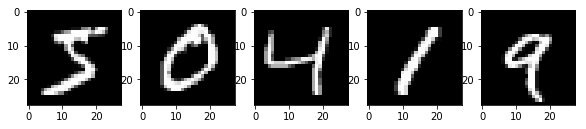

In [3]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i,:,:]
        plt.imshow(img, cmap='gray')
        
print('Test images:', test_images.shape)
print('Train images:', train_images.shape)
plot_images(5, train_images, 20)


## Prepare Data set.

In [4]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=False, image_dimensions=28):
    
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.image_dimensions = image_dimensions
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
        
    def flatten(self, images):
        return images.reshape((images.shape[0], -1))
    
    def reshape(self, images):
        return np.reshape(images, (images.shape[0], self.image_dimensions, self.image_dimensions))
    
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        # Reshape data, flattening.
        post_images = self.normalize(images)
#         post_images = self.flatten(post_images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = len(self.train_img)//batch_size
        for index in range(0, n_batches, batch_size):
            x = self.train_img[index:index+batch_size]
            y = self.train_labels[index:index+batch_size]
            yield x, y

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)
        
#         images = 1-images
        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))

        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))

        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))
                

## Encoder Qphi(Z/X) & Decoder Ptheta(X/Z)

In [5]:
class VAE():
    def __init__(self, dim_img, dim_x, dim_z, hidden_dim, learning_rate, batch_size, latent_samples=1, epsilon=1e-6):
        
        # Parameters.
        self.learning_rate = learning_rate
        self.latent_samples = latent_samples
        self.batch_size = batch_size
        self.epsilon = epsilon
        
        # Inputs.
        self.x_input = tf.placeholder(shape=(None, dim_img, dim_img), dtype=tf.float32, name='imput_image')
        self.z_input = tf.placeholder(shape=(None, dim_z), dtype=tf.float32, name='input_latent')
        
        # Model.
        self.weigth_init = tf.contrib.layers.xavier_initializer(uniform=False)
        self.vae_loss, self.vae_opt = self.model(self.x_input, self.z_input, dim_img, dim_x, dim_z, hidden_dim, name='model')
        
        # Tensorboard scalars and images.
        tf.summary.scalar('vae_loss', self.vae_loss)
        tf.summary.scalar('kl_divergence', self.kl_divergence)
        tf.summary.scalar('sampling_expt', self.sampling_expt)
        tf.summary.image('Input_Image_X', tf.reshape(self.x_input*255, (-1, dim_img, dim_img, 1)))
        tf.summary.image('Reconstruction', tf.cast(tf.reshape(self.p_x_given_z_recon*255, (-1, dim_img, dim_img, 1)), dtype=tf.float32))
        tf.summary.histogram("Encoder/Mean", self.mean_z_given_xi)
        tf.summary.histogram("Encoder/LogSimaSq", self.logs2_z_given_xi)
        tf.summary.histogram("Z_sample", self.z_sample_xi)
        tf.summary.histogram("Generator/Mean", self.mean_xi_given_z)
        tf.summary.histogram("Generator/LogSimaSq", self.logs2_xi_given_z)
        self.merged_summary_op = tf.summary.merge_all()
        
        # Variable initializer.
        self.init = tf.global_variables_initializer()
        
    def encoder(self, images, dim_z, hidden_dim, reuse, name):
        
        with tf.variable_scope(name_or_scope=name, reuse=reuse) as scope:
            # X Shape (Batch_size, dim_x).
            x_flatten = tf.layers.flatten(inputs=images, name='flattening')
            
            # Hidden Layer (Batch_size, dim_hidden).
            hidden_qphi_1 = tf.layers.dense(inputs=x_flatten, units=hidden_dim, activation=tf.nn.relu, kernel_initializer=self.weigth_init, name='hidden_layer_qphi_1')
            
            # Mean & Sigma, positive numbers softplus on the latter since it cannot be negative. 
            # Output Shape = (Batch_size, dim_z).
            mean_z_given_xi = tf.layers.dense(inputs=hidden_qphi_1, units=dim_z, activation=None, kernel_initializer=self.weigth_init, name='mean_z_given_xi')
            logs2_z_given_xi = tf.layers.dense(inputs=hidden_qphi_1, units=dim_z, activation=None, kernel_initializer=self.weigth_init, name='logs2_z_given_xi')
        return mean_z_given_xi, logs2_z_given_xi

    
    def decoder(self, z_sample_given_xi, dim_img, dim_x, hidden_dim, reuse, name):
        
        with tf.variable_scope(name_or_scope=name, reuse=reuse) as scope:
            # Input Layer (Batch_size, dim_z).

            # Hidden Layer (Batch_size, dim_hidden).
            hidden_ptheta_1 = tf.layers.dense(inputs=z_sample_given_xi, units=hidden_dim, activation=tf.nn.relu, kernel_initializer=self.weigth_init, name='hidden_layer_ptheta_1')
            
            # Need to introduce tf.contrib.distributions.Independent() to tell tensorflow that the hight and Width dimensions belong to the same data point.  
            # For CNN, here we are just reshaping.
            mean_xi_given_z = tf.layers.dense(inputs=hidden_ptheta_1, units=dim_x, activation=tf.sigmoid, kernel_initializer=self.weigth_init, name='mean_xi_given_z')
            logs2_xi_given_z = tf.layers.dense(inputs=hidden_ptheta_1, units=dim_x, activation=None, kernel_initializer=self.weigth_init, name='logs2_xi_given_z')
            mean_xi_given_z = tf.reshape(tensor=mean_xi_given_z, shape=(-1, dim_img, dim_img))
            logs2_xi_given_z = tf.reshape(tensor=logs2_xi_given_z, shape=(-1, dim_img, dim_img))
            
        return mean_xi_given_z, logs2_xi_given_z

    
    def parametrization_sample(self, mean_z_given_xi, logs2_z_given_xi, dim_z):
        sigma_z_given_xi = tf.sqrt(tf.exp(self.logs2_z_given_xi))
        
        normal = tf.random_normal(shape=tf.shape(mean_z_given_xi), mean=0.0, stddev=1.0, dtype=tf.float32)
        
        return normal*sigma_z_given_xi + mean_z_given_xi
        
    
    def model(self, x_input, z_input, dim_img, dim_x, dim_z, hidden_dim, name):
        with tf.variable_scope(name) as scope:
            '''
            ENCODER.
            Mean and Sigma from datapoint Xi. Shape = (Batch_size, dim_z).
            In the encoder, the neural network is able to approximate fairly well the s.t.d. for the latent space of the given sample Xi.
            '''
            self.mean_z_given_xi, self.logs2_z_given_xi = self.encoder(x_input, dim_z, hidden_dim, reuse=False, name='Qphi_z_given_x')
            
            '''
            PARAMETRIZATION TRICK.
            Building Normal distribution and pushes mean, scale s.t.d.
            Makes sure that Tensorflow takes into account that mean and sigma are parameter so it propagates gradients. 
            Get sample Z from the conditional distribution given Xi.
            Each dim z r.v is independent from each other, we assume that the covariance between them is 0.
            
            Trying two different way here:
                A. 1st way, create normal and parameterized it. Sample.
                B. 2nd way, sample from normal and scale.
            
            '''
#             q_z_given_x = tfp.distributions.MultivariateNormalDiag(loc=self.mean_z_given_xi, scale_diag=self.sigma_z_g_xi)
#             assert q_z_given_x.reparameterization_type == tfp.distributions.FULLY_REPARAMETERIZED
#             self.z_sample_xi = q_z_given_x.sample()

            self.z_sample_xi = self.parametrization_sample(self.mean_z_given_xi, self.logs2_z_given_xi, dim_z)
            
            '''
            P(Z)
            Modeling P(z) as a Normal distribution.
            Shape = (Batch_size, dim_z).
            Not needed if you go for the 2nd.
            '''
#             location = tf.zeros_like(self.mean_z_given_xi)
#             scale = tf.ones_like(self.sigma_z_g_xi)
#             self.p_z = tfp.distributions.MultivariateNormalDiag(loc=location, scale_diag=scale)
            
            '''
            DECODER.
            Shape = (Batch_size, dim_x).
            '''
            self.mean_xi_given_z, self.logs2_xi_given_z = self.decoder(self.z_sample_xi, dim_img, dim_x, hidden_dim, reuse=False, name='Ptheta_x_given_x')
            self.p_x_given_z_recon = self.mean_xi_given_z
            
            '''
            DISTRIBUTIONS FOR ENCODER.
            
            1. Gaussian.
                - Important Note: If we use the NN to approximate the s.t.d. the error in approximation will introduce noise and scale it when you doing the log_prob,
                since this s.t.d. will go into a log, with a lower value than one scaling the approximation problem.
                The solution to this is to introduce directly the approximation error with log(sigma**2).
                - Furhter insight into this, not only the neural network is introducing the error int the approximation, since me approximate with the sample on the 
                latent space, this is also introduces an error than is later magnified by the NN and the log function.
                - Besides, it needs the epsilon (1e-6) to be stable, otherwise Encoder mean will finish being NaN.
                p_x_given_z = tfp.distributions.Independent(tfp.distributions.MultivariateNormalDiag(loc=self.mean_xi_given_z, scale_diag=self.sigma_xi_given_z))
                assert p_x_given_z.reparameterization_type == tfp.distributions.FULLY_REPARAMETERIZED
                
            2. Bernoulli
                p_x_given_z = tfp.distributions.Independent(tfp.distributions.Bernoulli(logits=self.mean_xi_given_z), reinterpreted_batch_ndims=2).
                self.p_x_given_z_recon = p_x_given_z.sample().
            '''
            
            '''
            ELBO and Loss.
            ELBO: Building lower bound, the intent is to maximize this so the log(P(Xi)) maximizes.
            Two ways of implementing this according to the parametrization trick: 
                - Careful here with the balance on the reduce_sum/mean.
                - KL Divergence: Q(Z/X) and P(Z).
                    1. Use KL divergence form TensorFlow Probability Library:
                        self.kl_divergence = tf.reduce_sum(tfp.distributions.kl_divergence(distribution_a=q_z_given_x, distribution_b=self.p_z), axis=-1)
                    2. Compute KL divergence analytically.
                - Reconstruction error from sampled enconding:
                    1. Use log_prob from TensorFlow Probability Library.
                    2. Compute analytically for pdf:
                        2.a Gaussian.
                        2.b Bernoulli: self.sampling_expt = tf.reduce_sum(p_x_given_z.log_prob(self.x_input), axis=-1)
            Loss: We try to maximize the lower bound, so our objective is to minimize our loss.
            '''
            
            # KL Divergence.
            z_sigma_2 = tf.exp(self.logs2_z_given_xi)
            z_log_sigma_2 = tf.log(z_sigma_2 + self.epsilon)
            mean_z_2 = tf.square(self.mean_z_given_xi)
            self.kl_divergence= -.5*tf.reduce_sum(1 + z_log_sigma_2 -mean_z_2 -z_sigma_2, axis=-1)
            self.kl_divergence = tf.reduce_mean(-self.kl_divergence, axis=-1)
            
            # Recon error from encoding space of datapoint.
            x_sigma_2 = tf.exp(self.logs2_xi_given_z)
            exp_ls2 = tf.square(self.x_input - self.mean_xi_given_z)/(self.epsilon + x_sigma_2)
            se = tf.log(2*np.pi) + tf.log(self.epsilon + x_sigma_2) + exp_ls2
            self.sampling_expt = tf.reduce_sum(-.5*se, axis=[1,2])
            self.sampling_expt = tf.reduce_mean(self.sampling_expt, axis=-1)

            elbo = self.kl_divergence + self.sampling_expt
            vae_loss = -elbo
            vae_opt = tf.train.AdamOptimizer(self.learning_rate).minimize(vae_loss)
            
            '''
            Generator to sample.
            Shape = (Batch_size, dim_x).
            '''
            self.generated_mean, self.generated_logs2 = self.decoder(self.z_input, dim_img, dim_x, hidden_dim, reuse=True, name='Ptheta_x_given_x')
        
        return vae_loss, vae_opt

In [6]:
# Auxiliary function to plot generated digits.
def plot_samples(vae, sess, lat_img_run, e):
    
    # Normal distribution to generate images.
    location = tf.zeros((1, dim_z))
    scale = tf.ones((1, dim_z))
    normal = tfp.distributions.MultivariateNormalDiag(loc=location, scale_diag=scale)
    z_input = np.array(normal.sample(36).eval())
    z_input = z_input[:, 0, :]
    
    generated = sess.run(vae.generated_mean, feed_dict={vae.z_input: z_input})
    
    n_sqrt = int(np.sqrt(generated.shape[0]))
    fig, axes = plt.subplots(n_sqrt, n_sqrt, sharex=True, sharey=True, figsize=(n_sqrt*3, n_sqrt*3))
    for ii, ax in zip(range(0, generated.shape[0]), axes.flatten()):
        ax.imshow(generated[ii, :, :]*255, aspect='equal', cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig( '%s/%s.png' % (lat_img_run, e))
    plt.close()


## Parameters.

In [39]:
show_every = 1000
show_latent = 250

distribut = 'Init_Gaussian'
layers = 2

# GPU Options
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Model options.
batch_size = 20
dim_img = 28
dim_x = dim_img**2
dim_z = 25
hidden_dim = 250
lr = 1e-4
epochs = int(5e3)

# Directories.
run_name = '%s-%s-layer-full-bs_%s_dimz_%s_dimh_%s_lr_%s' % (distribut, layers, batch_size, dim_z, hidden_dim, lr)
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/MnistVAE/VAE/'
tensorboard_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/MnistVAE/VAE/tensorboard'
latent_images = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/MnistVAE/VAE/latent_images'
tb_session = '%s/%s' % (tensorboard_path, run_name)
lat_img_run = '%s/%s' % (latent_images, run_name)
if os.path.isdir(tb_session):
    shutil.rmtree(tb_session)
if os.path.isdir(lat_img_run):
    shutil.rmtree(lat_img_run)
os.makedirs(tb_session)
os.makedirs(lat_img_run)

# Tensor tracking.
run_metadata = tf.RunMetadata()

tf.reset_default_graph()
vae = VAE(dim_img=dim_img, dim_x=dim_x, dim_z=dim_z, hidden_dim=hidden_dim, learning_rate=lr, batch_size=batch_size)
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path)
    

Total Parameters:  608868
model:
	Qphi_z_given_x:
		hidden_layer_qphi_1:
			kernel:0 - shape: (784, 250) param: 196000 
			bias:0 - shape: (250,) param: 250 
		mean_z_given_xi:
			kernel:0 - shape: (250, 25) param: 6250 
			bias:0 - shape: (25,) param: 25 
		logs2_z_given_xi:
			kernel:0 - shape: (250, 25) param: 6250 
			bias:0 - shape: (25,) param: 25 
	Ptheta_x_given_x:
		hidden_layer_ptheta_1:
			kernel:0 - shape: (25, 250) param: 6250 
			bias:0 - shape: (250,) param: 250 
		mean_xi_given_z:
			kernel:0 - shape: (250, 784) param: 196000 
			bias:0 - shape: (784,) param: 784 
		logs2_xi_given_z:
			kernel:0 - shape: (250, 784) param: 196000 
			bias:0 - shape: (784,) param: 784 


In [13]:

iteration = 0
with tf.Session(config=config) as sess:

    summary_writer = tf.summary.FileWriter(tb_session, graph_def=sess.graph_def)
    sess.run(vae.init)
    for e in range(epochs+1):
        for images, labels in data.batches(batch_size):
        
            # maximum across all sessions and .run calls so far
#             a = sess.run(tf.contrib.memory_stats.MaxBytesInUse())
#             print(a)
            # current usage
#             b = sess.run(tf.contrib.memory_stats.BytesInUse())
#             print(b)
            
            # Train and store data 
            sess.run(vae.vae_opt, feed_dict={vae.x_input: images})
            summary_str, vae_loss, vae_mean_z_g_xi = sess.run([vae.merged_summary_op, vae.vae_loss, vae.mean_z_given_xi], feed_dict={vae.x_input: images}, options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE, output_partition_graphs=True), run_metadata=run_metadata)
            summary_writer.add_summary(summary_str, iteration)

            with open("%s/run2.txt" % os.getcwd(), "w") as out:
                out.write(str(run_metadata))
            
            if iteration%show_every==0:
                
                # Run batch and print loss.
                print('Epoch %s/%s... VAE Loss: %s' % (str(e), str(epochs), str(vae_loss)))
            iteration += 1

        if e%show_latent == 0:
            summary_str, mean_z_g_xi = sess.run([vae.merged_summary_op, vae.mean_z_given_xi], feed_dict={vae.x_input: data.test_img})
            summary_writer.add_summary(summary_str, iteration)
            plot_samples(vae, sess, lat_img_run, e)

    data.create_sprite_image(data.test_img[:2500])
    data.create_tsv_file(data.test_labels[:2500])
    mean_z_g_xi = sess.run(vae.mean_z_given_xi, feed_dict={vae.x_input: data.test_img[:2500]})
    latent = tf.Variable(mean_z_g_xi, name='Latent_Space_Z_%s' % e)

    saver = tf.train.Saver([latent])
    sess.run(latent.initializer)
    saver.save(sess, os.path.join(tb_session, 'latent_%s.ckpt' % e))
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = latent.name
    embedding.sprite.image_path = data.sprite
    embedding.sprite.single_image_dim.extend([28,28])
    embedding.metadata_path = data.metadata_tsv

    projector.visualize_embeddings(summary_writer, config)


InternalError: Failed to create CUPTI subcriber.